In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np
import seaborn as sns

In order to set-up the dataset I had to download it by folllowing an online procedure. 
The dataset was dismissed by torchivision and it is not more available.

The directory structure should be:

└── stanford_cars 
    └── cars_test_annos_withlabels.mat 
    └── cars_train
        └── *.jpg
    └── cars_test
        └── .*jpg
    └── devkit
        ├── cars_meta.mat
        ├── cars_test_annos.mat
        ├── cars_train_annos.mat
        ├── eval_train.m
        ├── README.txt
        └── train_perfect_preds.txt

In [5]:
# Load the dataset
dataset = torchvision.datasets.StanfordCars(root="./")

Displayed a few random images from the dataset to better understand the type of images I am working with.

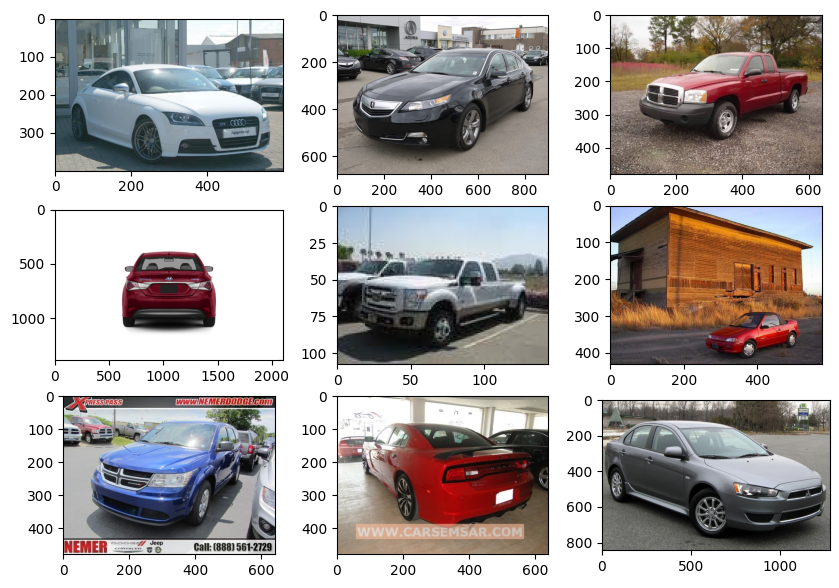

In [6]:
# Display some random images of the dataset
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(dataset[i * 3 + j][0])
        ax[i, j].axis("on")
plt.show()

In [7]:
# Define transformations for training and validation sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.StanfordCars(root="./", split='train', transform=transform_train)
val_dataset = datasets.StanfordCars(root="./", split='test', transform=transform_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

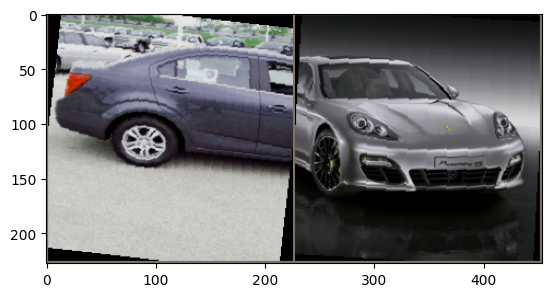

In [8]:
# Display some augmented images from the training set
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_augmented_images(dataloader):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out)

# Create a DataLoader for visualization with a small batch size
vis_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Display some augmented images
show_augmented_images(vis_loader)

In [9]:
# Load pretrained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in the Stanford Cars dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)  # Stanford Cars dataset has 196 classes

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = model.to(device)

print(f"Using device: {device}")
print(f"Device: {device}")

/Users/carpanini24/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/carpanini24/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: mps
Device: mps


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
# Function to create a new run directory
def create_new_run_dir(base_log_dir):
    run_number = 0
    while os.path.exists(os.path.join(base_log_dir, f"{run_number:04d}")):
        run_number += 1
    new_run_dir = os.path.join(base_log_dir, f"{run_number:04d}")
    os.makedirs(new_run_dir)
    return new_run_dir

# Base log directory
base_log_dir = "./runs/StanfordCars/"

# Create a new run directory
log_dir = create_new_run_dir(base_log_dir)
writer = SummaryWriter(log_dir)

In [12]:
num_epochs = 25

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.float() / len(train_dataset)

    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.float() / len(val_dataset)

    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Step the scheduler
    scheduler.step()

# Close the TensorBoard writer
writer.close()

Epoch 1/25
Train Loss: 5.2914 Acc: 0.0129
Val Loss: 5.0241 Acc: 0.0378
Epoch 2/25
Train Loss: 4.8893 Acc: 0.0516
Val Loss: 4.4535 Acc: 0.0990
Epoch 3/25
Train Loss: 4.4308 Acc: 0.1038
Val Loss: 3.9328 Acc: 0.1705
Epoch 4/25
Train Loss: 4.0328 Acc: 0.1691
Val Loss: 3.4586 Acc: 0.2414
Epoch 5/25
Train Loss: 3.6939 Acc: 0.2220
Val Loss: 3.0774 Acc: 0.3159
Epoch 6/25
Train Loss: 3.3796 Acc: 0.2834
Val Loss: 2.7136 Acc: 0.3776
Epoch 7/25
Train Loss: 3.1160 Acc: 0.3405
Val Loss: 2.4188 Acc: 0.4478
Epoch 8/25
Train Loss: 2.8949 Acc: 0.4032
Val Loss: 2.3403 Acc: 0.4845
Epoch 9/25
Train Loss: 2.8718 Acc: 0.4129
Val Loss: 2.2978 Acc: 0.4943
Epoch 10/25
Train Loss: 2.8318 Acc: 0.4207
Val Loss: 2.2568 Acc: 0.5027
Epoch 11/25
Train Loss: 2.7939 Acc: 0.4430
Val Loss: 2.2252 Acc: 0.5064
Epoch 12/25
Train Loss: 2.7714 Acc: 0.4360
Val Loss: 2.2026 Acc: 0.5192
Epoch 13/25
Train Loss: 2.7558 Acc: 0.4376
Val Loss: 2.1681 Acc: 0.5234
Epoch 14/25
Train Loss: 2.7149 Acc: 0.4425
Val Loss: 2.1521 Acc: 0.5287
E

In [13]:
torch.save(model.state_dict(), 'trained_model.pth')

In [14]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

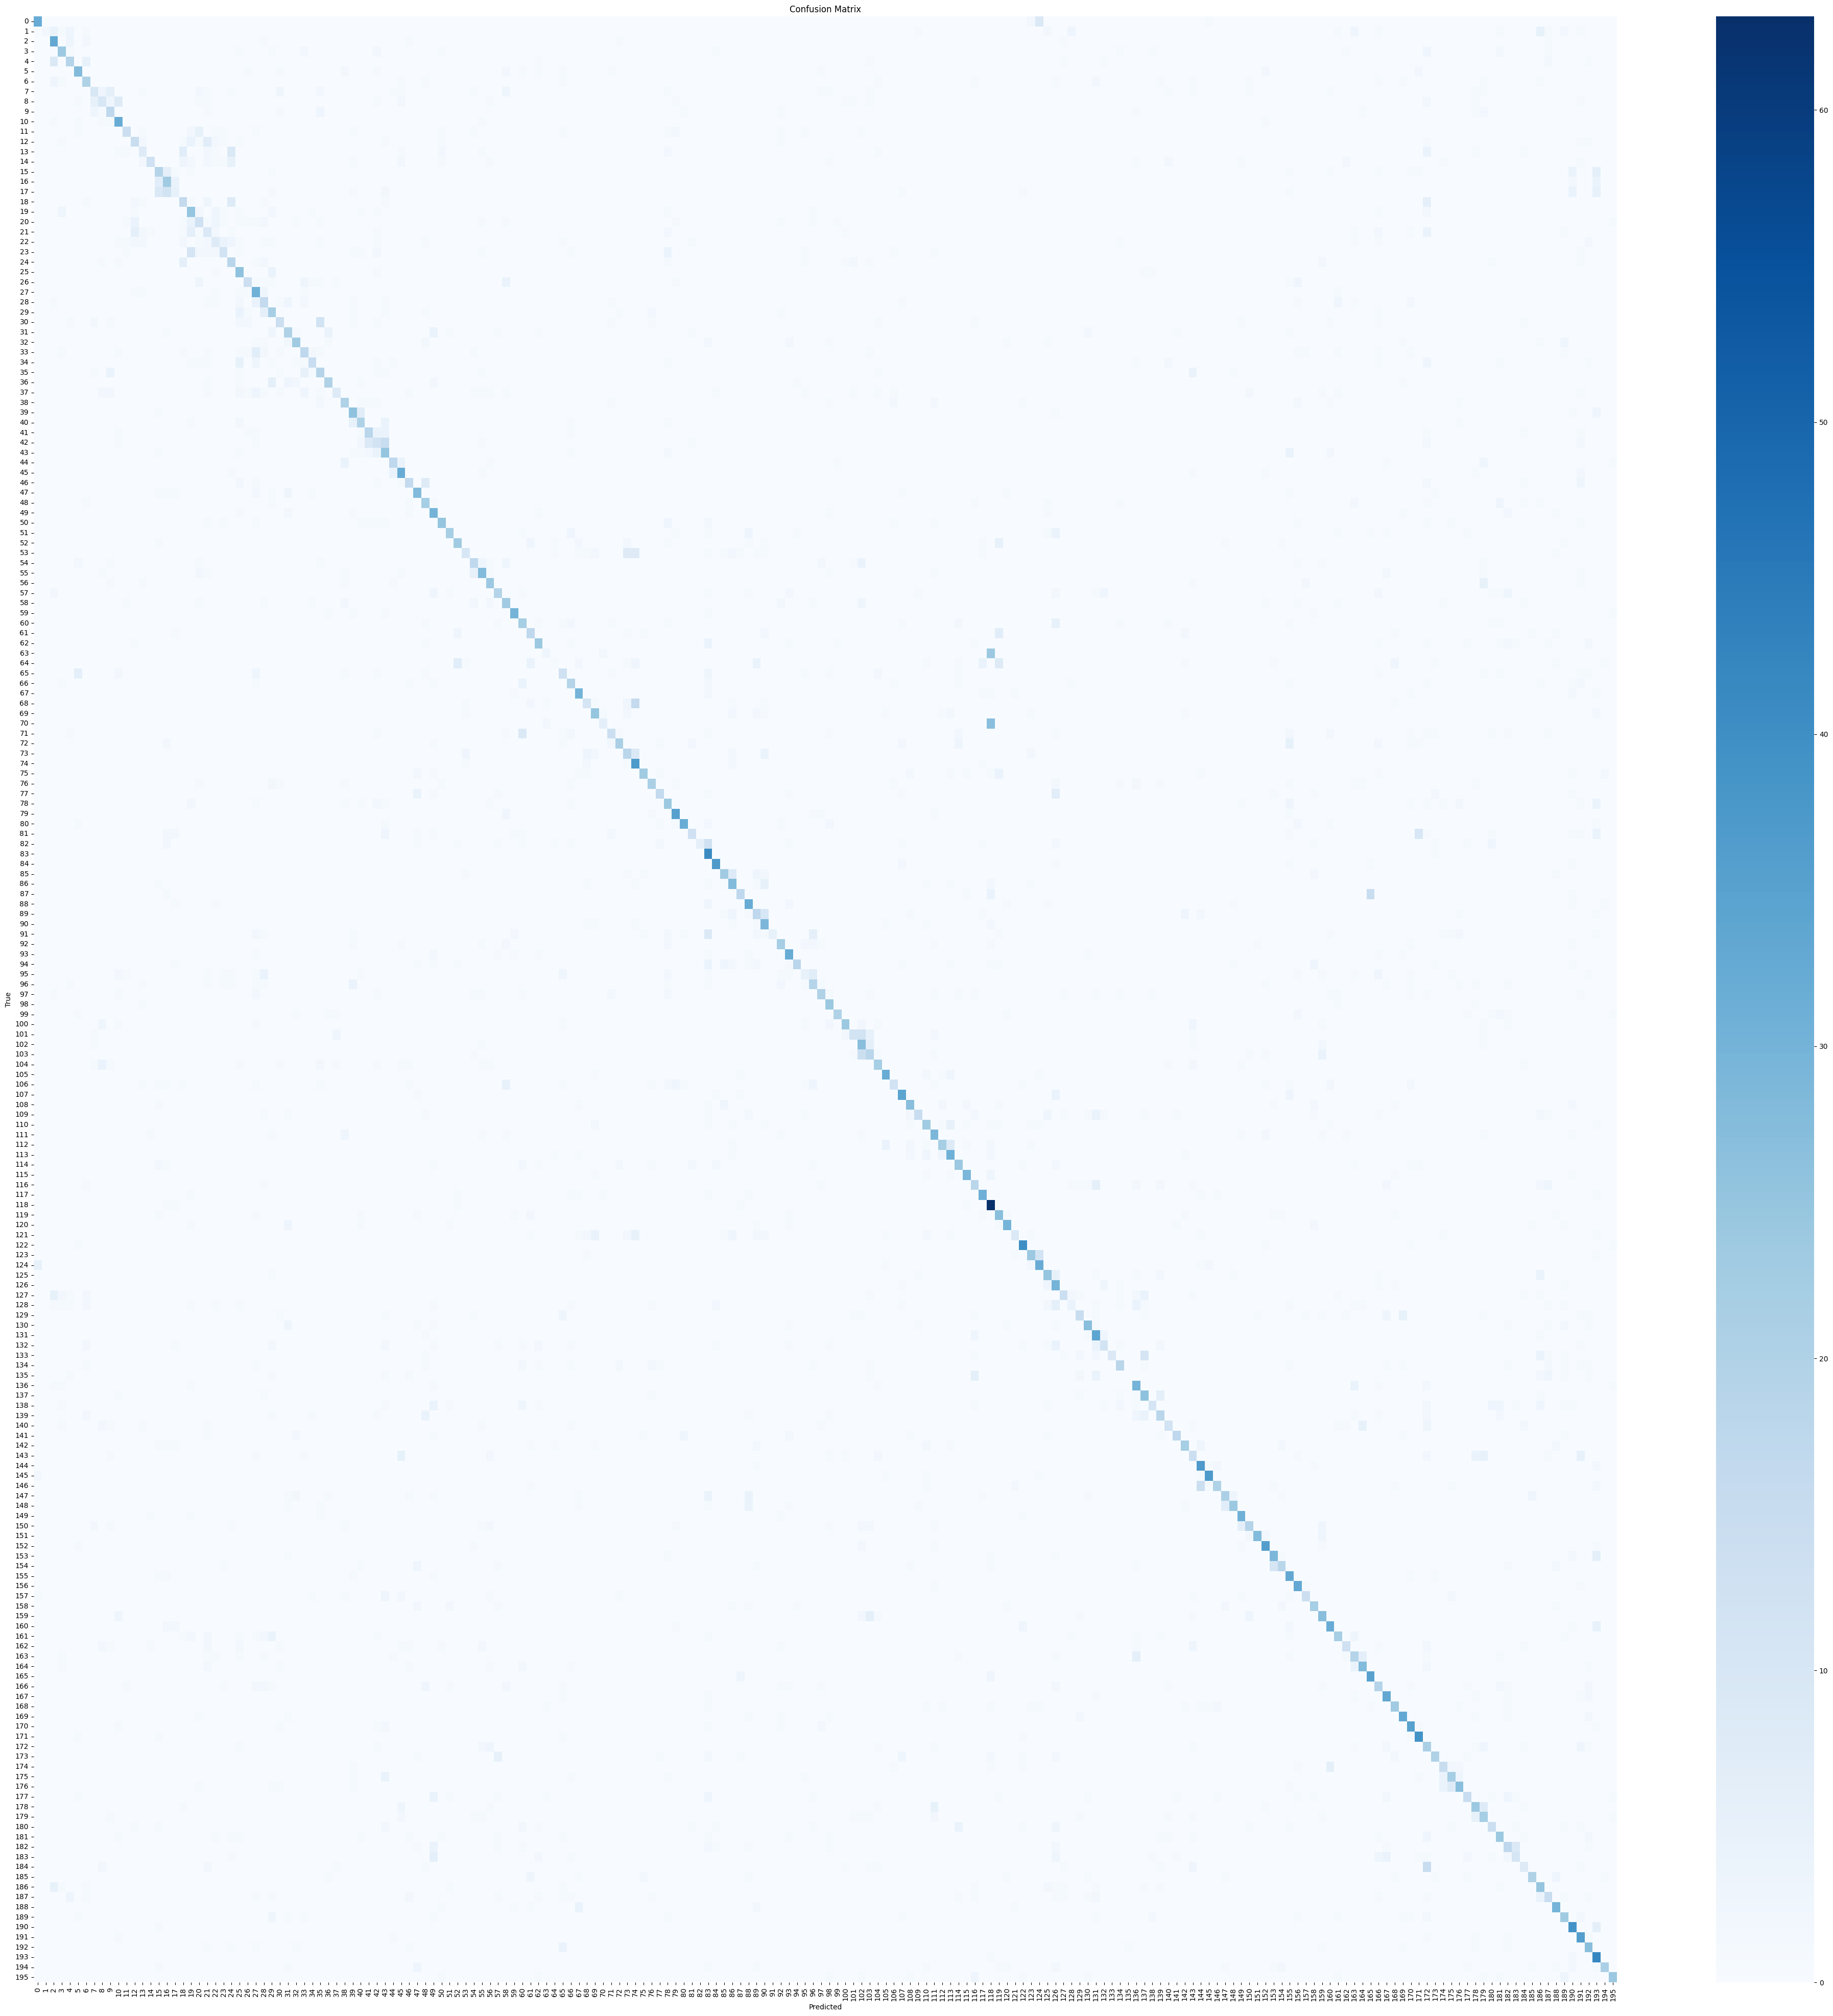

In [16]:
# Plot the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=range(196), yticklabels=range(196))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [23]:
# Ensure the model is in evaluation mode
model.eval()

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of validation data
inputs, labels = next(iter(val_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Forward pass to get predictions
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Define a list of class names if available
class_names = [str(i) for i in range(196)]  # Modify this with actual class names if available

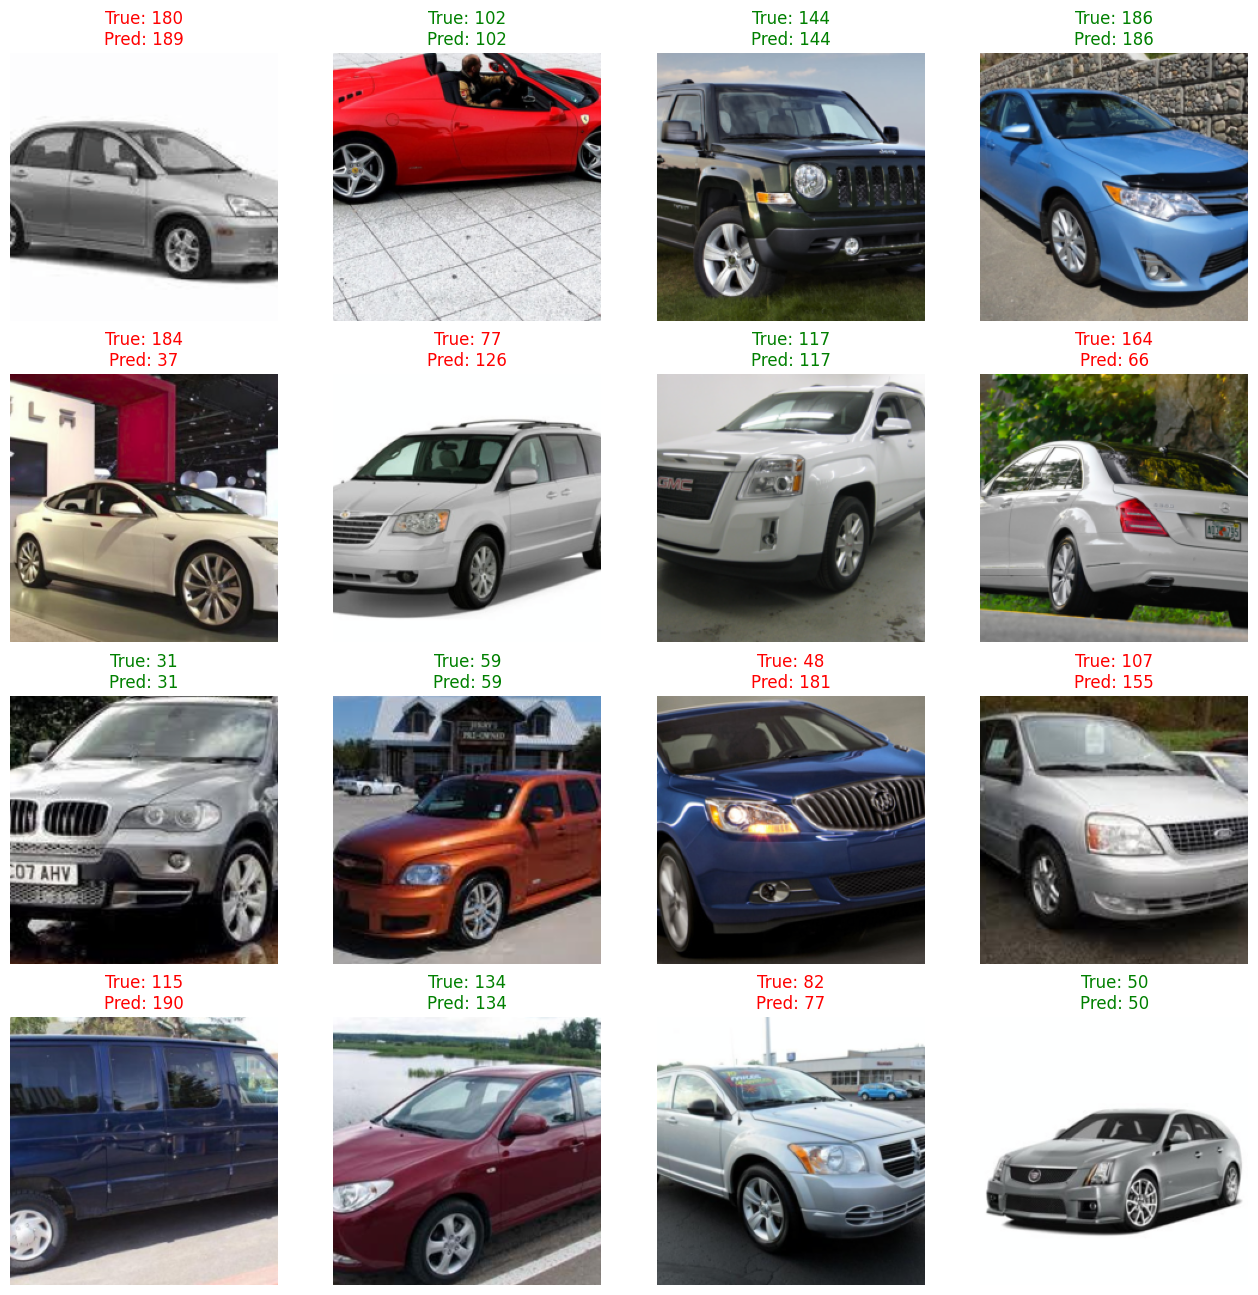

In [32]:
# Display images with predictions and true labels
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    imshow(inputs.cpu().data[i])
    true_label = class_names[labels[i].item()] if class_names else labels[i].item()
    pred_label = class_names[preds[i].item()] if class_names else preds[i].item()
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=("green" if true_label == pred_label else "red"))
    ax.axis('off')

plt.show()